# DECEPTIVE REVIEW CLASSIFIER

In [ ]:
!pip install --upgrade transformers
!pip install simpletransformers
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

     |████████████████████████████████| 2.8 MB 12.8 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 3.3 MB 37.4 MB/s 
     |████████████████████████████████| 636 kB 38.9 MB/s 
     |████████████████████████████████| 895 kB 45.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 221 kB 12.4 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.7 MB 49.2 MB/s 
     |████████████████████████████████| 8.0 MB 41.1 MB/s 
     |████████████████████████████████| 264 kB 55.0 MB/s 
     |████████████████████████████████| 1.2 MB 51.4 MB/s 
     |████████████████████████████████| 124 kB 51.0 MB/s 
     |████████████████████████████████| 170 kB 47.4 MB/s 
     |████████████████████████████████| 133 kB 45.4 MB/s 
     |████████████████████████████████| 97 

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=e13dffef23103737277cd12964f15cf9d85616fd8d26791a071954296abe03ba
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  |     Proc size: 120.9 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total     11441MB


In [ ]:
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
from scipy.special import softmax
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 200

def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(2)

In [ ]:
# specify GPU
device = torch.device("cuda")

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import statistics
import math
import os
from sklearn.metrics import log_loss
from sklearn.metrics import *
from sklearn.model_selection import *
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
pd.set_option('max_colwidth', 800)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#loading dataset
df=pd.read_csv('/content/deceptive.csv')
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,hyatt,positive,TripAdvisor,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [ ]:
# checking the no of rows and columns of the dataset
df.shape

(1600, 5)

In [ ]:
#checking the count of the deceptive column
df['deceptive'].value_counts()

deceptive    800
truthful     800
Name: deceptive, dtype: int64

In [ ]:
#checking the count of the polarity column
df['polarity'].value_counts()

positive    800
negative    800
Name: polarity, dtype: int64

This is perfectly balanced dataset. Our target variable is 'deceptive'.

In [ ]:
#checking the count of the hotel column
df['hotel'].value_counts()

affinia             80
ambassador          80
conrad              80
hardrock            80
sheraton            80
omni                80
intercontinental    80
sofitel             80
swissotel           80
palmer              80
homewood            80
amalfi              80
allegro             80
monaco              80
hyatt               80
fairmont            80
knickerbocker       80
james               80
talbott             80
hilton              80
Name: hotel, dtype: int64

In [ ]:
# checking the count of the source column
df['source'].value_counts()

MTurk          800
TripAdvisor    400
Web            400
Name: source, dtype: int64

### DATA PREPROCESSING AND EDA

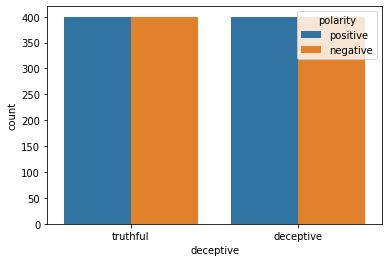

In [ ]:
import seaborn as sns
sns.countplot(x=df['deceptive'],hue='polarity',data=df)

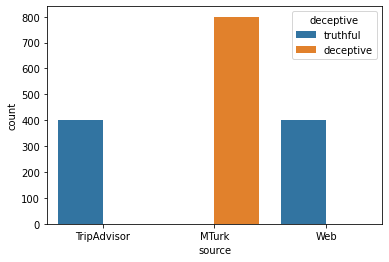

In [ ]:
sns.countplot(x=df['source'],hue='deceptive',data=df)

In [ ]:
df.columns

Index(['deceptive', 'hotel', 'polarity', 'source', 'text'], dtype='object')

In [ ]:
# dropping unnecessary columns. 
# dropping hotel names
# dropping the source of the data
# dropping the polarity of the dataset
df.drop(['hotel', 'polarity', 'source'], axis = 1, inplace=True)
df.head()

,deceptive,text
0,truthful,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [ ]:
z = {'truthful' : 1, 'deceptive' : 0}  # 1 for truthful reviews and 0 for deceptive reviews
df['deceptive'] = df['deceptive'].map(z)

In [ ]:
df.head()

,deceptive,text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,1,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [ ]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets and numbers
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)
    
    return text

In [ ]:
# applying that into function.
df["clean_text"] = df['text'].apply(lambda x: clean_text(x))
df.head(10)

,deceptive,text,clean_text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n",We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n",Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h...",This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n",The Omni Chicago really delivers on all front

In [ ]:
# dropping the uncleaned text column "text"
df = df.drop(['text'], axis=1)

In [ ]:
# renaming the column
df.rename(columns = {'clean_text':'text', 'deceptive' : 'label'}, inplace = True)
df.head()

,label,text
0,1,We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,The Omni Chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue While this address in Chicago requires a high level of quality the Omni delivers Check in for myself and a whole group of people with me was under minutes the staff had plentiful recommendations for dining and events and the rooms are some of the largest you ll find at this price range in Chicago Even the standard room has a separate living area and work desk The fitness center has free weights weight machines and two rows of cardio equipment I shared the room with others and did not feel cramped in any way All in all a great property
4,1,I asked for a high floor away from the elevator and that is what I got The room was pleasantly decorated functional and very clean I didn t need a whole lot of service but when I did they were pleasant and prompt I used the fitness center which was well equipped and everything was in working order It is in a great location at one end of the Michigan Avenue shopping district


In [ ]:
# shuffling the data
df = df.sample(frac=1).reset_index(drop=True)

### WORD VISUALIZATION

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
#making worldcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'s', 'she', 'against', 'below', 'each', "won't", 'o', 'both', "that'll", 'hers', 'through', 'here', 'he', 'down', 'off', 'there', 'not', 'hasn', 'is', 'an', 'am', 'you', 'do', 'who', 'only', 'before', 'most', 'd', 'mustn', 'on', 'more', 'when', 'we', 'mightn', 'weren', 'over', 'themselves', 'so', 'with', 'for', 'was', "you'll", 'our', 'or', 'if', 'few', 'than', 'will', "shan't", 'be', 'above', 'the', 'have', 'whom', 'needn', 'wasn', "you're", 'again', 'yourselves', 'as', 'under', 'aren', 'and', 'other', 're', 'it', 'because', 'these', 'while', 'out', 'where', 'herself', 'has', 'this', 'that', "you've", 'm', "couldn't", 'such', "wouldn't", 'myself', "didn't", 'did', 'are', 'in', "doesn't", 't', 'until', "don't", "mightn't", 'very', 'them', 'how', 'having', 'of', "she's", 'being', 'hadn', "you'd", 'a', 'after', 'own', 'ain', "isn't", 'my', "haven't", 'but', "hasn't", 'yours', "aren't", "mustn't", 'too', 'those', "needn't", 'theirs', "weren't", 'up', 'didn', 'ours', 'isn', 'doesn', 'shou

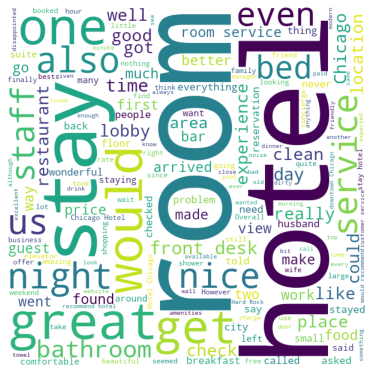

In [ ]:
# visualizing the most frequent words using matplot library
comment_words = ' '
for words in df['text']: 
    comment_words = comment_words + words + ' '
    
wordcloud = WordCloud(width = 600, height = 600, 
                background_color='white' , 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

In [ ]:
X = df['text']
y = df['label']

### TRAIN - TEST SPLIT

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)


## BERT APPROACH

BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks

We will fine-tune the model using the train set and the validation set, and make predictions for the test set. 

Import BERT Model and BERT Tokenizer. We will import the BERT-base model that has 110 million parameters. There is an even bigger BERT model called BERT-large that has 345 million parameters.

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


As you can see the output is a dictionary of two items.

    ‘input_ids’ contains the integer sequences of the input sentences. The integers 101 and 102 are special tokens. We add them to both the sequences, and 0 represents the padding token.
    ‘attention_mask’ contains 1’s and 0’s. It tells the model to pay attention to the tokens corresponding to the mask value of 1 and ignore the rest.


### TOKENIZE THE SENTENCES

Since the messages (text) in the dataset are of varying length, therefore we will use padding to make all the messages have the same length. We can use the maximum sequence length to pad the messages. However, we can also have a look at the distribution of the sequence lengths in the train set to find the right padding length.

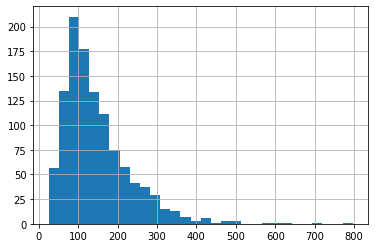

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

We can clearly see that most of the messages have a length of 300 words or less. Whereas the maximum length is 800. So, if we select 800 as the padding length then all the input sequences will have length 800 and most of the tokens in those sequences will be padding tokens which are not going to help the model learn anything useful and on top of that, it will make the training slower.

Therefore, we will set 300 as the padding length.

In [ ]:
max_seq_len = 300

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

Next, we will convert the integer sequences to tensors.

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

Now we will create dataloaders for both train and validation set. These dataloaders will pass batches of train data and validation data as input to the model during the training phase.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

freeze all the layers of the model before fine-tuning it.
[Freezing a layer in the context of neural networks is about controlling the way the weights are updated. When a layer is frozen, it means that the weights cannot be modified further.] This will prevent updating of model weights during fine-tuning. 

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

### Bert model architecture.

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

We will use AdamW as our optimizer. It is an improved version of the Adam optimizer. 

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1. 1.]


### Fine-Tune BERT:

So, till now we have defined the model architecture, we have specified the optimizer and the loss function, and our dataloaders are also ready. Now we have to define a couple of functions to train (fine-tune) and evaluate the model, respectively.

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

We will use the following function to evaluate the model. It will use the validation set data.

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

Now we will finally start fine-tuning of the model.

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 0.746
Validation Loss: 0.682

 Epoch 2 / 10

Evaluating...

Training Loss: 0.691
Validation Loss: 0.656

 Epoch 3 / 10

Evaluating...

Training Loss: 0.672
Validation Loss: 0.647

 Epoch 4 / 10

Evaluating...

Training Loss: 0.653
Validation Loss: 0.613

 Epoch 5 / 10

Evaluating...

Training Loss: 0.616
Validation Loss: 0.597

 Epoch 6 / 10

Evaluating...

Training Loss: 0.602
Validation Loss: 0.613

 Epoch 7 / 10

Evaluating...

Training Loss: 0.598
Validation Loss: 0.708

 Epoch 8 / 10

Evaluating...

Training Loss: 0.590
Validation Loss: 0.554

 Epoch 9 / 10

Evaluating...

Training Loss: 0.590
Validation Loss: 0.596

 Epoch 10 / 10

Evaluating...

Training Loss: 0.595
Validation Loss: 0.768


In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))
print(confusion_matrix(test_y, preds))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       120
           1       0.80      0.72      0.76       120

    accuracy                           0.77       240
   macro avg       0.77      0.77      0.77       240
weighted avg       0.77      0.77      0.77       240

[[98 22]
 [33 87]]
